In [1]:
import pandas as pd
import re
import os
from openai import OpenAI
from google.colab import userdata
from nltk.util import ngrams
from scipy.stats import ttest_ind
from IPython.display import display
import pandas as pd
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [4]:


#load the 39 line dataset; excel file from the path
#df_39 = pd.read_csv('39_line_dataset.csv')
df_39 = pd.read_excel('39_line_dataset.xlsx')

#load the 811 line dataset; excel file from the path
df_811 = pd.read_excel('articles_no_headers_only.xlsx')

#Rename columns
df_39 = df_39.rename(columns={'Top queries': 'top_queries', 'ushmm_article': 'ushmm_article', 'GPT-4o Response': 'gpt4o_response','Gemini Response': 'gemini_response', 'Grok Response': 'grok_response', 'ushmm_article - Word Count': 'ushmm_article_word_count', 'GPT-4o Response - Word Count': 'gpt4o_response_word_count', 'Gemini Response - Word Count' : 'gemini_response_word_count', 'Grok Response - Word Count' : 'grok_response_word_count'})
df_811 = df_811.rename(columns={'original_query': 'top_queries', 'ushmm_article_no_headers': 'ushmm_article', 'chatgpt_4o_article_no_headers': 'gpt4o_response','gemini_article_no_headers': 'gemini_response', 'grok_article_no_headers': 'grok_response'})

print(df_39.head())
print(df_811.head())

    id                  top_queries  \
0   80        the armenian genocide   
1  171                  ms st louis   
2  178         bolshevik revolution   
3  199  when did antisemitism start   
4  231     effects of the holocaust   

                                       ushmm_article  \
0  Sometimes called the first genocide of the twe...   
1  The voyage of the *St. Louis*, a German ocean ...   
2  Since early 1917, Russia had been in a state o...   
3  Sometimes called "the longest hatred," antisem...   
4  In 1945, when Allied troops entered the concen...   

                                      gpt4o_response  \
0  The Armenian Genocide refers to the systematic...   
1  The **MS St. Louis** was a German ocean liner ...   
2  The Bolshevik Revolution, also known as the Oc...   
3  Antisemitism—hostility, prejudice, or discrimi...   
4  The Holocaust, which took place during World W...   

                                     gemini_response  \
0  The Armenian Genocide was a syst

# Define functions for obtaining similarity and readability metrics

## READABILITY METRICS

In [6]:
#Word Count

def word_count(text):
    #Returns the number of words in a given text using regex
    words = re.findall(r'\b\w+\b', text)
    return len(words)

#Flesch Reading Score
def count_sentences(text):
    """Counts the number of sentences based on punctuation."""
    return max(1, len(re.findall(r'[.!?]', text)))  # Avoid zero sentences

def count_words(text):
    """Counts the number of words in the text."""
    return max(1, len(text.split(" ")))  # Avoid division by zero

def count_syllables(word):
    """Counts the number of syllables in a word using regex heuristics."""
    word = word.lower()
    syllables = re.findall(r'[aeiouy]+', word)  # Matches vowel clusters
    if word.endswith(("es", "ed")) and len(syllables) > 1:
        syllables.pop()  # Discount silent syllables
    return max(1, len(syllables))

def count_total_syllables(text):
    """Counts the total number of syllables in the text."""
    words = re.findall(r'\b\w+\b', text)  # Extract words
    return sum(count_syllables(word) for word in words)

def flesch_reading_ease(text):
    """Calculates the Flesch Reading Ease Score."""
    words = count_words(text)
    sentences = count_sentences(text)
    syllables = count_total_syllables(text)

    asl = words / sentences  # Average Sentence Length
    asw = syllables / words  # Average Syllables per Word

    score = 206.835 - (1.015 * asl) - (84.6 * asw)
    return round(score, 2)

#Coleman Liau Index
def count_letters(text):
    """Counts the number of letters (A-Z, a-z) in the text."""
    return sum(c.isalpha() for c in text)

def count_sentences(text):
    """Counts the number of sentences based on punctuation."""
    return max(1, len(re.findall(r'[.!?]', text)))  # Avoid zero sentences

def coleman_liau_index(text):
    """Calculates the Coleman-Liau Index for readability assessment."""
    letters = count_letters(text)
    words = count_words(text)
    sentences = count_sentences(text)

    L = (letters / words) * 100  # Average letters per 100 words
    S = (sentences / words) * 100  # Average sentences per 100 words

    CLI = 0.0588 * L - 0.296 * S - 15.8
    return round(CLI, 2)

## SIMILARITY METRICS

In [7]:
# Set OpenAI key
os.environ['OPEN_AI_API_KEY'] = userdata.get("OPEN_AI_PROJECT_KEY")
client = OpenAI(api_key=os.environ.get("OPEN_AI_API_KEY"))

# Get embedding for a single text
def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=text, model=model).data[0].embedding

# Generate and store all embeddings for a given DataFrame
def generate_and_store_embeddings(df, text_columns, output_path, model="text-embedding-3-small"):
    embeddings_dict = {}
    for col in text_columns:
        print(f"Generating embeddings for: {col}")
        embeddings_dict[col + "_embedding"] = df[col].apply(lambda x: get_embedding(str(x)))
    embeddings_df = pd.DataFrame(embeddings_dict)
    embeddings_df.to_csv(output_path, index=False)
    return embeddings_df

# Load or generate embeddings
def load_or_generate_embeddings(df, text_columns, embed_csv_path):
    if os.path.exists(embed_csv_path):
        print("Loading precomputed embeddings from CSV...")
        embeddings_df = pd.read_csv(embed_csv_path)
        # Convert stringified lists back to actual lists
        for col in embeddings_df.columns:
            embeddings_df[col] = embeddings_df[col].apply(ast.literal_eval)
    else:
        print("Embedding CSV not found. Generating embeddings...")
        embeddings_df = generate_and_store_embeddings(df, text_columns, embed_csv_path)
    return embeddings_df

# Compute cosine similarity between two embeddings
def cosine_similarity_from_embeddings(embed1, embed2):
    embed1 = np.array(embed1).reshape(1, -1)
    embed2 = np.array(embed2).reshape(1, -1)
    return cosine_similarity(embed1, embed2)[0][0]

def cosine_similarity_text_2(text1, text2):
    #Calculate cosine similarity between two long text strings using TF-IDF
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]

In [8]:
#Jaccard Index



def jaccard_index(text1, text2, n=3):
    """Calculate Jaccard index using n-grams for better comparison of longer texts."""
    set1 = set(ngrams(text1.split(), n))
    set2 = set(ngrams(text2.split(), n))

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    return intersection / union if union != 0 else 0

# Apply readability/similarity functions

In [9]:
#This function calculates the individual metrics (cosine similarity, jaccard index, flesch score, coleman-liau) individually and returns a data frame with just the indivudal metrics
def process_text_comparisons_scores_only(df):

    # Ensure required columns exist
    required_columns = ["ushmm_article", "gpt4o_response", "gemini_response", "grok_response"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"CSV must contain the columns: {required_columns}")

    # Compute Readability and Word Count
    for col in required_columns:
        df[f"{col}_word_count"] = df[col].apply(word_count)
        df[f"{col}_flesch_score"] = df[col].apply(flesch_reading_ease)
        df[f"{col}_coleman_liau"] = df[col].apply(coleman_liau_index)

    # Pairwise Comparisons
    pairings = [
        ("ushmm_article", "gpt4o_response"),
        ("ushmm_article", "gemini_response"),
        ("ushmm_article", "grok_response"),
        ("gpt4o_response", "gemini_response"),
        ("gpt4o_response", "grok_response"),
        ("gemini_response", "grok_response"),
    ]

    for col1, col2 in pairings:
        df[f"{col1}_{col2}_cosine_sim"] = df.apply(lambda row: cosine_similarity_text_2(row[col1], row[col2]), axis=1)
        df[f"{col1}_{col2}_jaccard_index"] = df.apply(lambda row: jaccard_index(row[col1], row[col2]), axis=1)

    return df

scores_by_line_811 = process_text_comparisons_scores_only(df_811)
print(scores_by_line_811.head())
scores_by_line_39 = process_text_comparisons_scores_only(df_39)
print(scores_by_line_39.head())

   id                            top_queries  \
0   0  how many people died in the holocaust   
1   1                      armenian genocide   
2   2                 holocaust encyclopedia   
3   3                    first they came for   
4   6                          the holocaust   

                                       ushmm_article  \
0  Nazi Germany committed mass murder on an unpre...   
1  Sometimes called the first genocide of the twe...   
2  The Holocaust (1933–1945) was the systematic, ...   
3  \n> First they came for the socialists, and I ...   
4  The Holocaust (1933–1945) was the systematic, ...   

                                      gpt4o_response  \
0  Approximately 6 million Jews were killed durin...   
1  The Armenian Genocide was the systematic mass ...   
2  The Holocaust Encyclopedia is a comprehensive ...   
3  The phrase "First they came for..." is the ope...   
4  The Holocaust was the systematic, state-sponso...   

                                     

In [10]:
scores_by_line_39.to_csv('39_line_dataset_scores_only.csv', index=False)
scores_by_line_811.to_csv('811_line_dataset_scores_only.csv', index=False)

In [11]:
scores_by_line_811.columns.tolist()

['id',
 'top_queries',
 'ushmm_article',
 'gpt4o_response',
 'gemini_response',
 'grok_response',
 'ushmm_article_word_count',
 'ushmm_article_flesch_score',
 'ushmm_article_coleman_liau',
 'gpt4o_response_word_count',
 'gpt4o_response_flesch_score',
 'gpt4o_response_coleman_liau',
 'gemini_response_word_count',
 'gemini_response_flesch_score',
 'gemini_response_coleman_liau',
 'grok_response_word_count',
 'grok_response_flesch_score',
 'grok_response_coleman_liau',
 'ushmm_article_gpt4o_response_cosine_sim',
 'ushmm_article_gpt4o_response_jaccard_index',
 'ushmm_article_gemini_response_cosine_sim',
 'ushmm_article_gemini_response_jaccard_index',
 'ushmm_article_grok_response_cosine_sim',
 'ushmm_article_grok_response_jaccard_index',
 'gpt4o_response_gemini_response_cosine_sim',
 'gpt4o_response_gemini_response_jaccard_index',
 'gpt4o_response_grok_response_cosine_sim',
 'gpt4o_response_grok_response_jaccard_index',
 'gemini_response_grok_response_cosine_sim',
 'gemini_response_grok_re

#Composite Similarity Score

In [13]:
#Function for computing the composite similarity between two texts

#Takes in four input similarity metrics
# 1. cosine similarity between two texts
# 2. jaccard index between two texts
# 3. difference in flesch reading score between two texts
# 4. differences in coleman-liau score between two texts
# each of the values are normalized to a [0, 1] scale in which 0 is least similar and 1 is identical
# the values are combined into a weighted average score based on the weights assigned in the constant variables below. Cosine 0.4, Jaccard 0.3, Flesh 0.15, Coleman 0.15
COSINE_SIMILARITY_WEIGHT = 0.4
JACCARD_INDEX_WEIGHT = 0.3
FLESCH_SCORE_WEIGHT = 0.15
COLEMAN_LIAU_WEIGHT = 0.15
def composite_similarity(text1, text2):
    cos = cosine_similarity_text_2(text1, text2)
    jac = jaccard_index(text1, text2)
    flesch_sim = 1 - max(0, 1 - abs(flesch_reading_ease(text1) - flesch_reading_ease(text2)) / 100)
    cli_sim = 1 - abs(coleman_liau_index(text1) - coleman_liau_index(text2)) / 20
    return round(COSINE_SIMILARITY_WEIGHT * cos + JACCARD_INDEX_WEIGHT * jac + FLESCH_SCORE_WEIGHT * flesch_sim + COLEMAN_LIAU_WEIGHT * cli_sim, 4)


In [12]:
#Function for taking in a df of USHMM, GPT, Gemini, and Grok responses to queries  and computing the composite similarities between each responses for each query
def compute_composite_similarity_scores(df):
    """
    Prepares a DataFrame by selecting available columns, adding empty columns for similarity scores,
    and computing similarity between specified pairs of text fields only if both fields are present.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with similarity columns populated.
    """


    # Define the columns to keep
    columns_to_keep = [
        'id',
 'top_queries',
 'ushmm_article',
 'gpt4o_response',
 'gemini_response',
 'grok_response', 'ushmm_article_gpt4o_response_cosine_sim',
 'ushmm_article_gpt4o_response_jaccard_index',
 'ushmm_article_gemini_response_cosine_sim',
 'ushmm_article_gemini_response_jaccard_index',
 'ushmm_article_grok_response_cosine_sim',
 'ushmm_article_grok_response_jaccard_index',
 'gpt4o_response_gemini_response_cosine_sim',
 'gpt4o_response_gemini_response_jaccard_index',
 'gpt4o_response_grok_response_cosine_sim',
 'gpt4o_response_grok_response_jaccard_index',
 'gemini_response_grok_response_cosine_sim',
 'gemini_response_grok_response_jaccard_index',
    ]

    # Only keep columns that exist in df
    available_columns = [col for col in columns_to_keep if col in df.columns]
    df_new = df[available_columns].copy()

    # Define the new empty columns to add
    new_columns = [
        'ushmm_gpt_similarity', 'ushmm_gemini_similarity', 'ushmm_grok_similarity',
        'gpt_gemini_similarity', 'gpt_grok_similarity', 'gemini_grok_similarity'
    ]

    # Add the new empty columns
    for col in new_columns:
        df_new[col] = ""

    # Define the text column pairs for which similarity is computed
    pairs = [
        ("ushmm_article", "gpt4o_response", "ushmm_gpt_similarity"),
        ("ushmm_article", "gemini_response", "ushmm_gemini_similarity"),
        ("ushmm_article", "grok_response", "ushmm_grok_similarity"),
        ("gpt4o_response", "gemini_response", "gpt_gemini_similarity"),
        ("gpt4o_response", "grok_response", "gpt_grok_similarity"),
        ("gemini_response", "grok_response", "gemini_grok_similarity")
    ]

    # Compute the similarity for each pair only if both columns are present
    for col1, col2, new_col in pairs:
        if col1 in df_new.columns and col2 in df_new.columns:
            df_new[new_col] = df_new.apply(
                lambda row: composite_similarity(row[col1], row[col2]),
                axis=1
            )
        else:
            # Leave similarity column empty if one or both columns are missing
            df_new[new_col] = ""

    return df_new

In [14]:
df_39_with_composite = compute_composite_similarity_scores(scores_by_line_39)
df_811_with_composite = compute_composite_similarity_scores(scores_by_line_811)
print(df_39_with_composite.head())
print(df_811_with_composite.head())

    id                  top_queries  \
0   80        the armenian genocide   
1  171                  ms st louis   
2  178         bolshevik revolution   
3  199  when did antisemitism start   
4  231     effects of the holocaust   

                                       ushmm_article  \
0  Sometimes called the first genocide of the twe...   
1  The voyage of the *St. Louis*, a German ocean ...   
2  Since early 1917, Russia had been in a state o...   
3  Sometimes called "the longest hatred," antisem...   
4  In 1945, when Allied troops entered the concen...   

                                      gpt4o_response  \
0  The Armenian Genocide refers to the systematic...   
1  The **MS St. Louis** was a German ocean liner ...   
2  The Bolshevik Revolution, also known as the Oc...   
3  Antisemitism—hostility, prejudice, or discrimi...   
4  The Holocaust, which took place during World W...   

                                     gemini_response  \
0  The Armenian Genocide was a syst

In [15]:
df_39_with_composite.to_csv('39_line_dataset_with_composite.csv', index=False)
df_811_with_composite.to_csv('811_line_dataset_with_composite.csv', index=False)

# Run t-tests

In [16]:


def run_pairwise_t_tests(df):
    similarity_cols = [
        'ushmm_gpt_similarity', 'ushmm_gemini_similarity', 'ushmm_grok_similarity',
        'gpt_gemini_similarity', 'gpt_grok_similarity', 'gemini_grok_similarity'
    ]

    t_test_results = []

    # Perform pairwise t-tests between all combinations of similarity scores
    for col1, col2 in itertools.combinations(similarity_cols, 2):
        scores1 = df[col1].dropna()
        scores2 = df[col2].dropna()

        if len(scores1) > 1 and len(scores2) > 1:
            t_stat, p_val = ttest_ind(scores1, scores2, equal_var=False)
            t_test_results.append({
                "comparison": f"{col1} vs {col2}",
                "mean1": scores1.mean(),
                "mean2": scores2.mean(),
                "t_statistic": round(t_stat, 4),
                "p_value": round(p_val, 4),
                "significant_p_<_0.05": p_val < 0.05
            })
        else:
            t_test_results.append({
                "comparison": f"{col1} vs {col2}",
                "mean1": scores1.mean() if len(scores1) > 0 else None,
                "mean2": scores2.mean() if len(scores2) > 0 else None,
                "t_statistic": None,
                "p_value": None,
                "significant_p_<_0.05": None
            })

    results_df = pd.DataFrame(t_test_results)
    display(results_df)
    return results_df

In [17]:
t_test_39 = run_pairwise_t_tests(df_39_with_composite)
t_test_811 = run_pairwise_t_tests(df_811_with_composite)

,comparison,mean1,mean2,t_statistic,p_value,significant_p_<_0.05
0,ushmm_gpt_similarity vs ushmm_gemini_similarity,0.436926,0.433490,0.3554,0.7233,False
1,ushmm_gpt_similarity vs ushmm_grok_similarity,0.436926,0.434603,0.2497,0.8035,False
2,ushmm_gpt_similarity vs gpt_gemini_similarity,0.436926,0.477787,-4.6901,0.0000,True
3,ushmm_gpt_similarity vs gpt_grok_similarity,0.436926,0.484592,-5.7050,0.0000,True
4,ushmm_gpt_similarity vs gemini_grok_similarity,0.436926,0.482918,-5.3334,0.0000,True
5,ushmm_gemini_similarity vs ushmm_grok_similarity,0.433490,0.434603,-0.1166,0.9075,False
6,ushmm_gemini_similarity vs gpt_gemini_similarity,0.433490,0.477787,-4.9393,0.0000,True
7,ushmm_gemini_similarity vs gpt_grok_similarity,0.433490,0.484592,-5.9271,0.0000,True
8,ushmm_gemini_similarity vs gemini_grok_similarity,0.433490,0.482918,-5.5649,0.0000,True
9,ushmm_grok_similarity vs gpt_gemini_similarity,0.434603,0.477787,-5.0367,0.0000,True


,comparison,mean1,mean2,t_statistic,p_value,significant_p_<_0.05
0,ushmm_gpt_similarity vs ushmm_gemini_similarity,0.427946,0.392294,9.9903,0.0000,True
1,ushmm_gpt_similarity vs ushmm_grok_similarity,0.427946,0.414532,4.0321,0.0001,True
2,ushmm_gpt_similarity vs gpt_gemini_similarity,0.427946,0.423975,1.1618,0.2455,False
3,ushmm_gpt_similarity vs gpt_grok_similarity,0.427946,0.453718,-8.5606,0.0000,True
4,ushmm_gpt_similarity vs gemini_grok_similarity,0.427946,0.424978,0.8363,0.4031,False
5,ushmm_gemini_similarity vs ushmm_grok_similarity,0.392294,0.414532,-5.8469,0.0000,True
6,ushmm_gemini_similarity vs gpt_gemini_similarity,0.392294,0.423975,-8.1576,0.0000,True
7,ushmm_gemini_similarity vs gpt_grok_similarity,0.392294,0.453718,-17.3998,0.0000,True
8,ushmm_gemini_similarity vs gemini_grok_similarity,0.392294,0.424978,-8.1727,0.0000,True
9,ushmm_grok_similarity vs gpt_gemini_similarity,0.414532,0.423975,-2.5782,0.0100,True


# Calculate Cohen's d

In [18]:


def cohen_d(x, y):
    """Calculate Cohen's d for two independent samples."""
    x, y = np.array(x), np.array(y)
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((x.std(ddof=1) ** 2) + (y.std(ddof=1) ** 2)) / 2)
    return (x.mean() - y.mean()) / pooled_std

def calculate_pairwise_cohens_d(df, similarity_columns):
    """
    Calculates Cohen's d for all pairwise combinations of similarity columns.
    Parameters:
        df (pd.DataFrame): DataFrame containing similarity score columns.
        similarity_columns (list): List of column names to compare.

    Returns:
        pd.DataFrame: A table of pairwise comparisons and their Cohen's d values.
    """
    results = []

    for col1, col2 in itertools.combinations(similarity_columns, 2):
        scores1 = df[col1].dropna()
        scores2 = df[col2].dropna()
        d = cohen_d(scores1, scores2)
        results.append({
            "comparison": f"{col1} vs {col2}",
            "mean1": scores1.mean(),
            "mean2": scores2.mean(),
            "cohens_d": round(d, 4),
            "effect_size": interpret_cohens_d(d)
        })

    return pd.DataFrame(results)

def interpret_cohens_d(d):
    """Categorize effect size based on Cohen's d."""
    d = abs(d)
    if d < 0.2:
        return "Negligible"
    elif d < 0.5:
        return "Small"
    elif d < 0.8:
        return "Medium"
    else:
        return "Large"

In [19]:
#Append Cohen's d values to t_test results
def add_cohens_d_to_summary(summary_df, full_df, similarity_columns):
    """
    Calculates Cohen's d from full_df and merges the results into an existing summary_df.

    Parameters:
        summary_df (pd.DataFrame): Existing table with 'Comparison', 'Mean 1', 'Mean 2'
        full_df (pd.DataFrame): Data with composite score columns
        similarity_columns (list): List of column names to compute Cohen's d for

    Returns:
        pd.DataFrame: summary_df with 'Cohen\'s d' and 'Effect Size' columns appended
    """
    d_results = calculate_pairwise_cohens_d(full_df, similarity_columns)

    # Merge on 'Comparison'
    merged = summary_df.merge(d_results[["comparison", "cohens_d", "effect_size"]], on="comparison", how="left")
    return merged

similarity_columns = [
        'ushmm_gpt_similarity', 'ushmm_gemini_similarity', 'ushmm_grok_similarity',
        'gpt_gemini_similarity', 'gpt_grok_similarity', 'gemini_grok_similarity'
    ]


results_811 = add_cohens_d_to_summary(t_test_811, df_811_with_composite, similarity_columns)
results_39 = add_cohens_d_to_summary(t_test_39, df_39_with_composite, similarity_columns)

In [20]:
print(results_811)
print(results_39)

                                           comparison     mean1     mean2  \
0     ushmm_gpt_similarity vs ushmm_gemini_similarity  0.427946  0.392294   
1       ushmm_gpt_similarity vs ushmm_grok_similarity  0.427946  0.414532   
2       ushmm_gpt_similarity vs gpt_gemini_similarity  0.427946  0.423975   
3         ushmm_gpt_similarity vs gpt_grok_similarity  0.427946  0.453718   
4      ushmm_gpt_similarity vs gemini_grok_similarity  0.427946  0.424978   
5    ushmm_gemini_similarity vs ushmm_grok_similarity  0.392294  0.414532   
6    ushmm_gemini_similarity vs gpt_gemini_similarity  0.392294  0.423975   
7      ushmm_gemini_similarity vs gpt_grok_similarity  0.392294  0.453718   
8   ushmm_gemini_similarity vs gemini_grok_similarity  0.392294  0.424978   
9      ushmm_grok_similarity vs gpt_gemini_similarity  0.414532  0.423975   
10       ushmm_grok_similarity vs gpt_grok_similarity  0.414532  0.453718   
11    ushmm_grok_similarity vs gemini_grok_similarity  0.414532  0.424978   

In [ ]:
results_39.to_csv('39_line_dataset_results.csv', index=False)
results_811.to_csv('811_line_dataset_results.csv', index=False)

#Visualizations

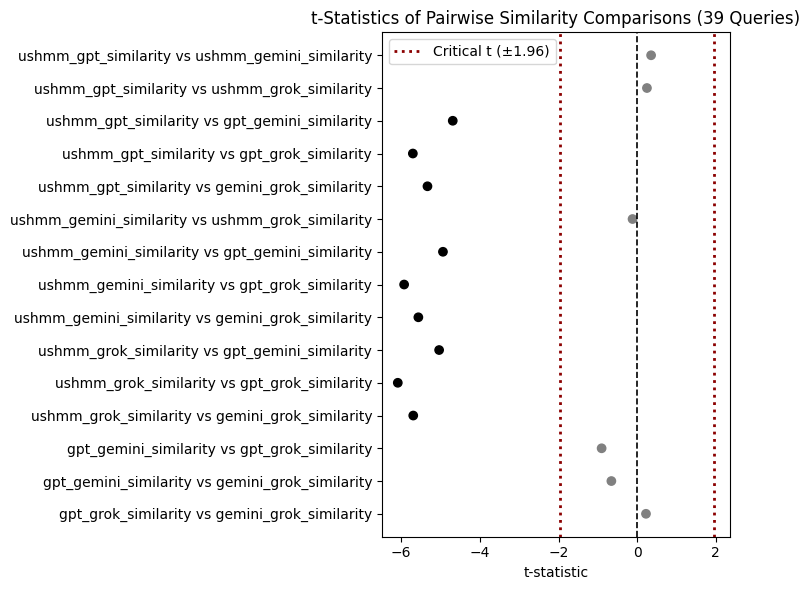

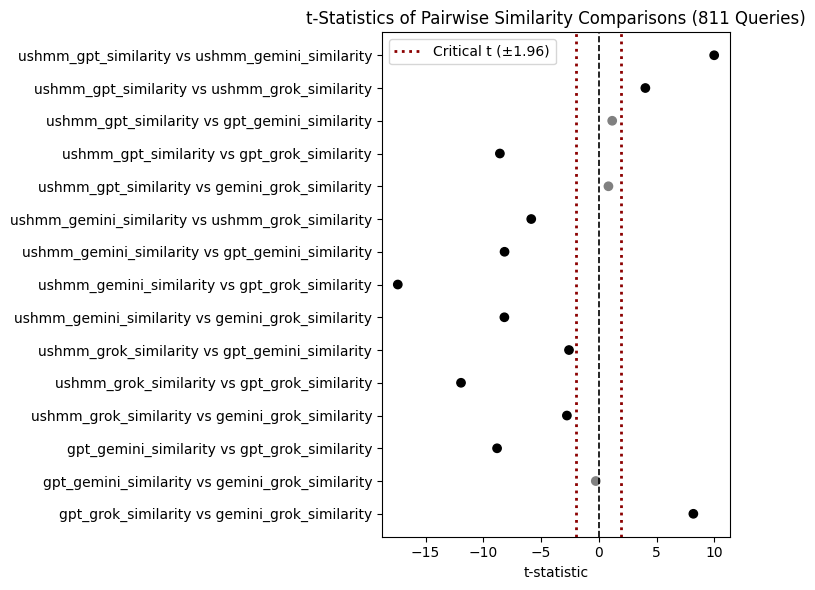

In [21]:
# Plot for 39 line dataset t test results

# Make comparisons appear in proper order
t_test_39 = t_test_39.iloc[::-1].reset_index(drop=True)

#Plot
fig, ax = plt.subplots(figsize=(7.5, 6))
colors = t_test_39["significant_p_<_0.05"].map({True: "black", False: "gray"})

ax.scatter(t_test_39["t_statistic"], t_test_39["comparison"], c=colors)

# Reference lines
ax.axvline(x=0, linestyle='--', color='black', linewidth=1.2)
ax.axvline(x=1.96, linestyle=':', color='darkred', linewidth=2, label='Critical t (±1.96)')
ax.axvline(x=-1.96, linestyle=':', color='darkred', linewidth=2)

# Labels and title
ax.set_xlabel("t-statistic")
ax.set_title("t-Statistics of Pairwise Similarity Comparisons (39 Queries)")
ax.legend()

plt.tight_layout()
fig.savefig("t_statistics_39_queries.png", dpi=1000, bbox_inches='tight')  # Save as high-res image

# Plot for 811 line dataset t test results

# Make comparisons appear in proper order
t_test_811 = t_test_811.iloc[::-1].reset_index(drop=True)

#Plot
fig, ax = plt.subplots(figsize=(7.5, 6))
colors = t_test_811["significant_p_<_0.05"].map({True: "black", False: "gray"})

ax.scatter(t_test_811["t_statistic"], t_test_811["comparison"], c=colors)

# Reference lines
ax.axvline(x=0, linestyle='--', color='black', linewidth=1.2)
ax.axvline(x=1.96, linestyle=':', color='darkred', linewidth=2, label='Critical t (±1.96)')
ax.axvline(x=-1.96, linestyle=':', color='darkred', linewidth=2)

# Labels and title
ax.set_xlabel("t-statistic")
ax.set_title("t-Statistics of Pairwise Similarity Comparisons (811 Queries)")
ax.legend()

plt.tight_layout()
fig.savefig("t_statistics_811_queries.png", dpi=1000, bbox_inches='tight')  # Save as high-res image

# Mean Table

In [ ]:
# List of similarity columns
similarity_columns = [
    "USHMM-GPT Similarity",
    "USHMM-Gemini Similarity",
    "USHMM-Grok Similarity",
    "GPT-Gemini Similarity",
    "GPT-Grok Similarity",
    "Gemini-Grok Similarity"
]

# Calculate means for both dataframes
means_39 = df_39_with_composite[similarity_columns].mean()
means_811 = df_811_with_composite[similarity_columns].mean()

# Combine into a summary table
mean_table = pd.DataFrame({
    "All Queries (n=811)": means_811,
    "Similar Word Count (n=39)": means_39
})

# Display the table
mean_table.index.name = "Similarity Metric"
mean_table.reset_index(inplace=True)
mean_table.round(4)  # round to 4 decimal places for readability

mean_table.to_csv('mean_table.csv', index=False)